In [45]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import blowtorch
from blowtorch import Run   
import rasterio
import fiona
from pathlib import Path
from datetime import datetime, timedelta
from typing import *
import seaborn as sns
import pandas as pd
import time
sns.set_style("whitegrid")
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")

def pjoin(*subs: List[Union[str,Path]]) -> Path: return Path(os.path.join(*subs))
def parse_date(date_str) -> datetime: return datetime.strptime(date_str, '%Y%m%d')

In [5]:
!ls

 assets				    ignore.create_dataset-1.yaml
 conditions_cp_distro.pdf	    ignore.download.yaml
 conditions_cp_distro.png	    ignore.eval.log
 config				    ignore.geeDL.log
 cp_masks			    ignore.geeDL.stderr.log
 credentials.json		    ignore.geeDL.stdout.log
 data				    ignore.json
 docs				    ignore.md
 drive.log			    ignore.py
 gee				    ignore.sh
 gee_data			    ignore.wandb_dl.yaml
 gee_data_dev			    ignore.wandb.py
'GEE Data inference.md'		    images
 gee_data_reprojected		    install_conda_env.sh
 gee_vs_original		    notebooks
 get_token_from_code.sh		    README.md
 ignore				    requirements.txt
 ignore.aggregate.yaml		    results
 ignore.cloud_exp.parallel.stderr   results_copy
 ignore.cloud_exp.parallel.stdout   run
 ignore.cloud_exp.stderr	    src
 ignore.cloud_exp.stdout	    token.json
 ignore.cp_masks.log		    wandb


In [9]:
run = Run(config_files=["config/create_dataset/baseline.yaml"])

# Collect dates by tif
- Sentinel-2: in file names
- Sentinel-1: in file names
- Ground truth: in shape collection attribute `PUB_DATO`

In [10]:
def collect_s1_dates(run):
    s1_asc, s1_desc = [], []
    for project_id in run["projects"]:
        for img_path in pjoin(run['s1_reprojected_dir'], project_id).glob('*.tif'):
            if img_path.stem.endswith('_A'):
                s1_list = s1_asc
            elif img_path.stem.endswith('_D'):
                s1_list = s1_desc
            else:
                raise ValueError(f'Could not extract orbit direction from filename: {img_path.name}')
            s1_list.append((project_id, parse_date(img_path.stem.split('_')[5].split('T')[0])))
    return s1_asc, s1_desc

def collect_s2_dates(run):
    s2  = []
    for project_id in run["projects"]:
        for img_path in pjoin(run['s2_reprojected_dir'], project_id).glob('*.tif'):
            s2.append((project_id, parse_date(img_path.stem.split('_')[3].split('T')[0])))
    return s2

def collect_gt_dates(run):
    gt = []
    project_shape_collections = [fiona.open(p) for p in run['project_shapefiles']]
    for project_id in run["projects"]:
        # create the shape ("polygon") associated to the project 
        for collection in project_shape_collections:
            try:
                _ = [s['geometry'] for s in collection if s['properties']['kv_id'] == int(project_id)][0]
                gt_date = [s["properties"]["PUB_DATO"] for s in collection if s['properties']['kv_id'] == int(project_id)][0]
                break
            except IndexError: pass 
        gt.append((project_id, gt_date))
    return gt

In [11]:
s1_asc, s1_desc = collect_s1_dates(run)
s2 = collect_s2_dates(run)
gt = collect_gt_dates(run)

In [105]:
df = {
    "src": ["S1A" for _ in range(len(s1_asc))] +
           ["S1B" for _ in range(len(s1_desc))] +
           ["S2" for _ in range(len(s2))] +
           ["GT" for _ in range(len(gt))],
    "project_id": [int(t[0]) for t in s1_asc] +
                  [int(t[0]) for t in s1_desc] +
                  [int(t[0]) for t in s2] +
                  [int(t[0]) for t in gt],
    "datetime": [t[1] for t in s1_asc] +
                [t[1] for t in s1_desc] +
                [t[1] for t in s2] +
                [t[1] for t in gt], 
}
df = pd.DataFrame(df)
df.sort_values(by=["project_id"], inplace=True)
df.project_id = df.project_id.astype("str")

/scratch/ewalt/miniconda3/envs/gdal-rio-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  from ipykernel import kernelapp as app


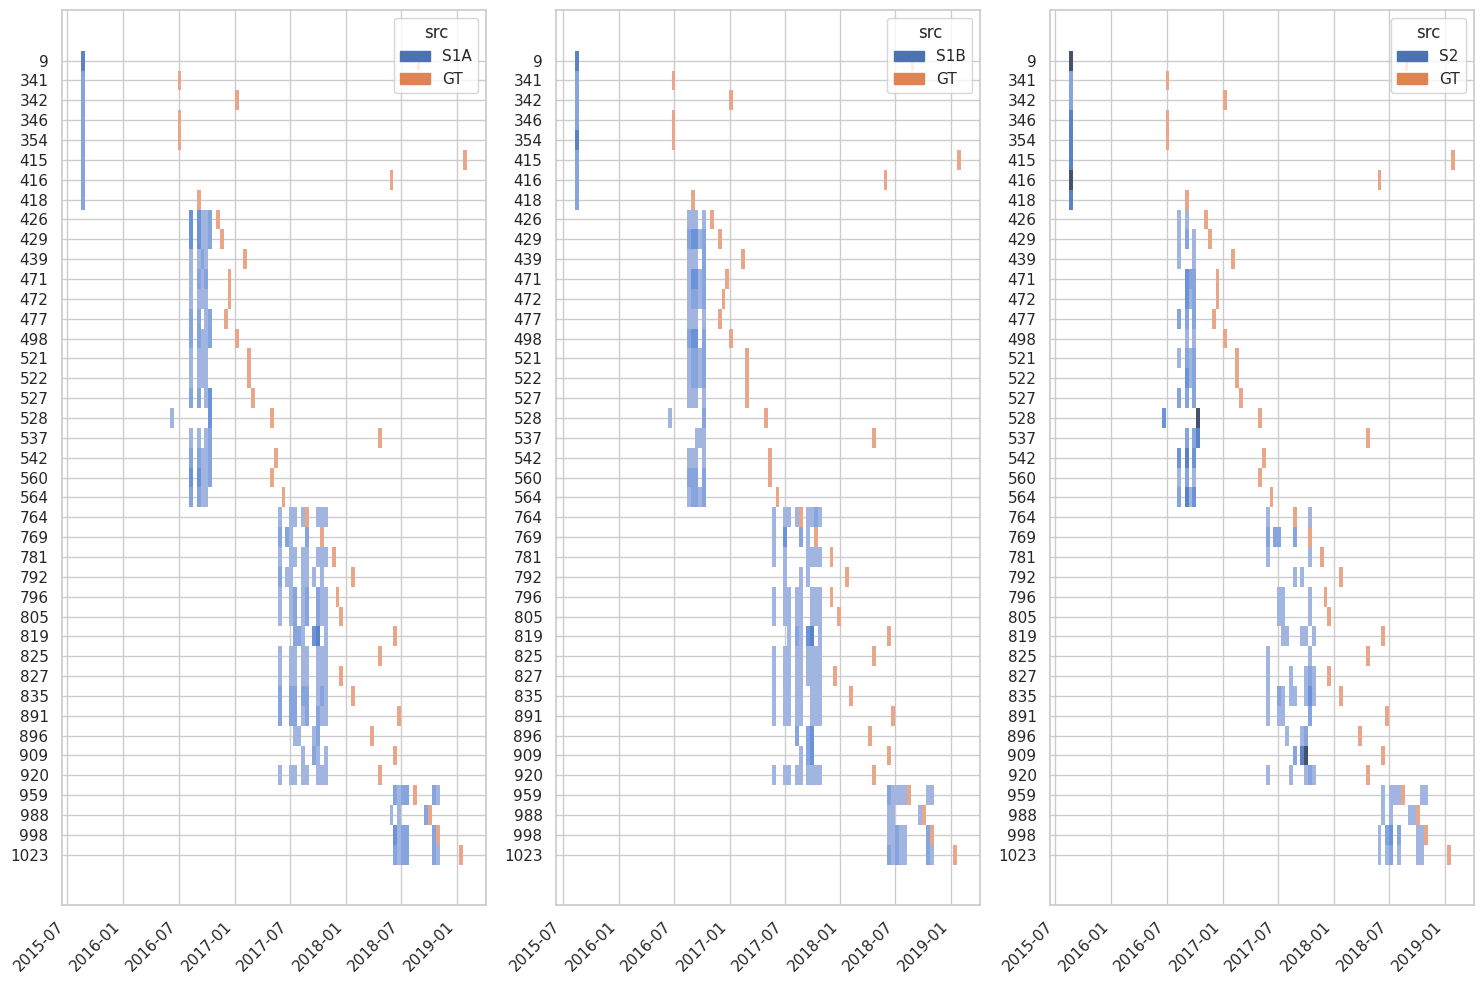

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(15,10))
g1_asc = sns.histplot(df[df.src.isin(["S1A","GT"])], x="datetime", y="project_id", discrete=(False, True), hue="src", bins=100, ax=axs[0], vmin=0, vmax=7)
g1_asc.set(xlabel=None, ylabel=None)
g1_desc = sns.histplot(df[df.src.isin(["S1B","GT"])], x="datetime", y="project_id", discrete=(False, True), hue="src", bins=100, ax=axs[1], vmin=0, vmax=7)
g1_desc.set(xlabel=None, ylabel=None)
g2 = sns.histplot(df[df.src.isin(["S2","GT"])], x="datetime", y="project_id", discrete=(False, True), hue="src", bins=100, ax=axs[2], vmin=0, vmax=7)
g2.set(xlabel=None, ylabel=None)
fig.autofmt_xdate(rotation=45)
# fig.suptitle("Dates distribution for each project and satellite")
plt.tight_layout()
plt.show()

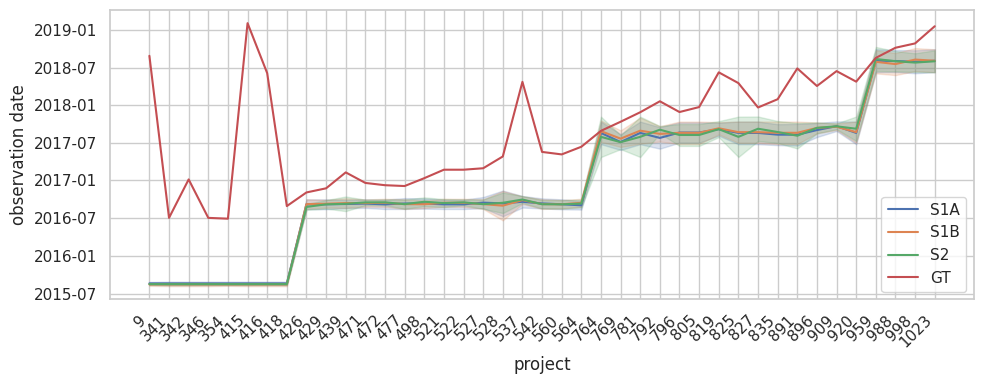

In [118]:
fig = plt.figure(figsize=(10,4))
ax=plt.gca()
sns.lineplot(df, y="datetime", x="project_id", hue="src", 
             hue_order=("S1A", "S1B", "S2", "GT"), ax=ax, errorbar="sd")
fig.autofmt_xdate(rotation=45)
#ax.set_xticklabels([])
ax.set_ylabel("observation date")
ax.set_xlabel("project")
ax.legend().set_title(None)
ax.legend(loc="lower right")
plt.tight_layout()
fig.savefig("images/albecker/triplet_dates.png", dpi=300)
fig.savefig("images/albecker/triplet_dates.pdf", dpi=200)
plt.show()

In [110]:
s2_shift_df = df.query("src == 'GT'").drop("src", axis=1).merge(
    df.query("src == 'S2'").drop("src", axis=1), on="project_id", suffixes=("_GT", "_S2"))
s2_shift_df = s2_shift_df.assign(
    time_shift=(s2_shift_df.datetime_GT-s2_shift_df.datetime_S2).dt.days,
    count=np.ones((s2_shift_df.shape[0],))
)
# s2_shift_df = s2_shift_df.groupby("time_shift")["count"].sum().reset_index()

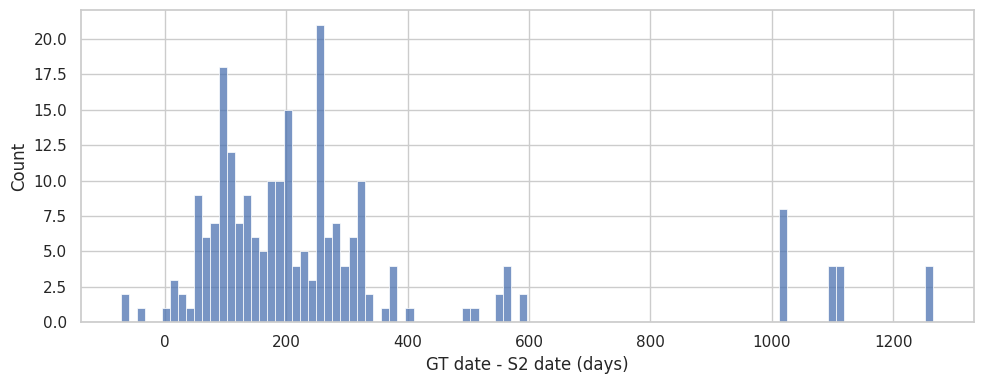

In [120]:
fig = plt.figure(figsize=(10,4))
ax = plt.gca()
sns.histplot(data=s2_shift_df, x="time_shift", ax=ax, bins=100)
ax.set_xlabel("GT date - S2 date (days)")
plt.tight_layout()
fig.savefig("images/albecker/gt2s2_date_shift.png", dpi=300)
fig.savefig("images/albecker/gt2s2_date_shift.pdf", dpi=200)
plt.show()

In [71]:
s2_shift_df.describe()

,time_shift,count
count,228.000000,228.0
mean,278.052632,1.0
std,283.166841,0.0
min,-72.000000,1.0
25%,112.500000,1.0
50%,198.000000,1.0
75%,299.000000,1.0
max,1266.000000,1.0


In [ ]:
s2_shift_df = pd.DataFrame({
    "time_shift": df.query()
})

In [102]:
df[df.project_id=="959"]

,src,project_id,datetime
446,s1_desc,959,2018-06-14
169,s1_asc,959,2018-07-14
168,s1_asc,959,2018-07-02
660,s2,959,2018-07-15
451,s1_desc,959,2018-07-14
448,s1_desc,959,2018-10-18
449,s1_desc,959,2018-06-08
170,s1_asc,959,2018-06-07
447,s1_desc,959,2018-10-30
445,s1_desc,959,2018-07-02


In [103]:
d = lambda x: datetime.strptime(x, "%Y-%m-%d")
time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime((d("2018-08-17")-d("2018-10-30")).total_seconds()))

'1969-10-19 00:00:00'

In [107]:
sec = 1132
min_ = sec/60
hours = min_/60
days = hours/24
months = days/30
years = months/12
years, months, min_

(3.63940329218107e-05, 0.0004367283950617284, 18.866666666666667)

In [95]:
1270/30

42.333333333333336

In [ ]:
days 